# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(azdias.head(3))

(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN  

In [5]:
print(feat_info.shape)
print(feat_info.head(3))

(85, 4)
              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.

# before changing any values, detect truly missing data across each column (no filler values)
def summarize_na_col(df):
    print('Column Name\tNA Values\tPercent NA')
    all_vals = df.shape[0]
    for column in df:
        na_vals = (df[column].isna() == True).sum()
        percent_na = str((na_vals/all_vals).round(2)*100) + '%'
        print(f'{column.lower()[0:15].ljust(15)}\t{str(na_vals).rjust(9)}\t{percent_na.rjust(9)}')
        
summarize_na_col(azdias)

Column Name	NA Values	Percent NA
ager_typ       	        0	     0.0%
alterskategorie	        0	     0.0%
anrede_kz      	        0	     0.0%
cjt_gesamttyp  	     4854	     1.0%
finanz_minimali	        0	     0.0%
finanz_sparer  	        0	     0.0%
finanz_vorsorge	        0	     0.0%
finanz_anleger 	        0	     0.0%
finanz_unauffae	        0	     0.0%
finanz_hausbaue	        0	     0.0%
finanztyp      	        0	     0.0%
geburtsjahr    	        0	     0.0%
gfk_urlaubertyp	     4854	     1.0%
green_avantgard	        0	     0.0%
health_typ     	        0	     0.0%
lp_lebensphase_	     4854	     1.0%
lp_lebensphase_	     4854	     1.0%
lp_familie_fein	     4854	     1.0%
lp_familie_grob	     4854	     1.0%
lp_status_fein 	     4854	     1.0%
lp_status_grob 	     4854	     1.0%
nationalitaet_k	        0	     0.0%
praegende_jugen	        0	     0.0%
retourtyp_bk_s 	     4854	     1.0%
semio_soz      	        0	     0.0%
semio_fam      	        0	     0.0%
semio_rel      	        0	     

In [7]:
# now we'll do replacement and run the above numbers again to see if they look any different

def make_col_val_replacement_dict(s):
    list_of_nums = s.replace('[','').replace(']','')
    if len(list_of_nums) == 0:
        return {}
    return dict(zip([int(s) if s.replace('-', '').isdigit() else s for s in list_of_nums.split(',') ], [np.nan]*len(list_of_nums)))

feat_info.head()
replacement_dict = dict(zip(
    feat_info['attribute'],
    feat_info['missing_or_unknown'].apply(make_col_val_replacement_dict)
))

In [8]:
# now we'll do replacement and run the above numbers again to see if they look any different
nanned = azdias.replace(replacement_dict)
nanned.head()
# summarize_na_col(nanned)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 31.,   1.,   0.,   0.,   0.,   0.,   0.,   7.,   8.,  10.,   6.,
          7.,   6.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([      0.        ,   10459.54117647,   20919.08235294,
          31378.62352941,   41838.16470588,   52297.70588235,
          62757.24705882,   73216.78823529,   83676.32941176,
          94135.87058824,  104595.41176471,  115054.95294118,
         125514.49411765,  135974.03529412,  146433.57647059,
         156893.11764706,  167352.65882353,  177812.2       ,
         188271.74117647,  198731.28235294,  209190.

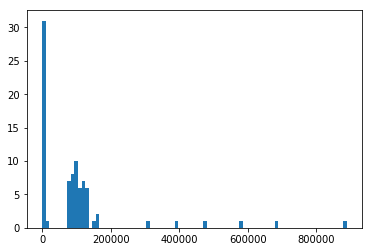

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

def get_na_counts_col(df):
    return [((df[column].isna() == True).sum(), column) for column in df]

counts_with_col_names = get_na_counts_col(nanned)
# print(counts_with_col_names)
bins = len(set([c[1] for c in counts_with_col_names]))
plt.hist([c[0] for c in counts_with_col_names], bins=bins)

In [10]:
# from plot above, identify any col that is missing more than 200,000 values

na_cols = [c[1] for c in counts_with_col_names if c[0] > 200000]
print(na_cols)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [11]:
# Investigate patterns in the amount of missing data in each column.

# Remove the outlier columns from the dataset.
na_cols_dropped = nanned.drop(na_cols, axis=1)

# so now we can again summarize NA cols using a reduced dataset
summarize_na_col(na_cols_dropped)


Column Name	NA Values	Percent NA
alterskategorie	     2881	     0.0%
anrede_kz      	        0	     0.0%
cjt_gesamttyp  	     4854	     1.0%
finanz_minimali	        0	     0.0%
finanz_sparer  	        0	     0.0%
finanz_vorsorge	        0	     0.0%
finanz_anleger 	        0	     0.0%
finanz_unauffae	        0	     0.0%
finanz_hausbaue	        0	     0.0%
finanztyp      	        0	     0.0%
gfk_urlaubertyp	     4854	     1.0%
green_avantgard	        0	     0.0%
health_typ     	   111196	    12.0%
lp_lebensphase_	    97632	    11.0%
lp_lebensphase_	    94572	    11.0%
lp_familie_fein	    77792	     9.0%
lp_familie_grob	    77792	     9.0%
lp_status_fein 	     4854	     1.0%
lp_status_grob 	     4854	     1.0%
nationalitaet_k	   108315	    12.0%
praegende_jugen	   108164	    12.0%
retourtyp_bk_s 	     4854	     1.0%
semio_soz      	        0	     0.0%
semio_fam      	        0	     0.0%
semio_rel      	        0	     0.0%
semio_mat      	        0	     0.0%
semio_vert     	        0	     

#### Discussion 1.1.2: Assess Missing Data in Each Column

Looking at the plot above, it's easy to identify the outliers in terms of columns that are missing data. I chose 200,000 as a threshold, because most columns had fewer missing values than this number. You can even see a bit of a normal distribution on the left side of the histogram above.

Here are the columns that I removed using the aforementioned threshold: AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX.

After removing those columns, I ran a summarization of the remaining columns in terms of NA values present in those columns. By looking at that summarization, you can see that a majority of the remaining columns contain 15% or less of NaN values. You can also see that some of the amounts/percentages of missing values are grouped together in similar columns, e.g., the _plz8_ columns and the _kba05_ columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
def get_na_counts_row(df):
    return [(row.isna().sum(), idx) for idx, row in df.iterrows()]

counts_with_row_idx = get_na_counts_row(na_cols_dropped)

(array([  6.23209000e+05,   1.57380000e+04,   2.79260000e+04,
          1.76290000e+04,   1.26070000e+04,   2.25150000e+04,
          1.37710000e+04,   1.37140000e+04,   2.45920000e+04,
          3.04200000e+03,   5.41000000e+03,   1.12700000e+03,
          7.66000000e+02,   3.25500000e+03,   2.24300000e+03,
          4.74300000e+03,   2.50500000e+03,   6.77000000e+02,
          4.28000000e+02,   1.18000000e+03,   3.49000000e+02,
          1.50000000e+02,   1.29000000e+02,   1.32000000e+02,
          6.90000000e+01,   5.50000000e+01,   5.90000000e+01,
          2.40000000e+01,   5.00000000e+00,   1.20000000e+01,
          6.00000000e+00,   3.00000000e+00,   2.06000000e+02,
          2.98500000e+03,   1.08160000e+04,   3.91100000e+03,
          8.40000000e+01,   5.38000000e+02,   4.21000000e+02,
          7.70000000e+01,   1.37000000e+02,   3.56000000e+02,
          2.10000000e+01,   2.73690000e+04,   1.55000000e+02,
          4.94000000e+02,   0.00000000e+00,   4.55780000e+04,
        

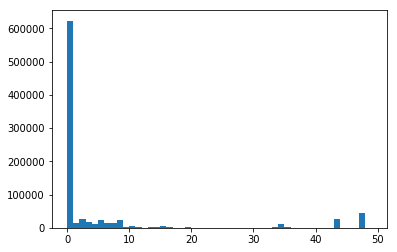

In [13]:
bins = len(set([c[0] for c in counts_with_row_idx]))
plt.hist([c[0] for c in counts_with_row_idx], bins=bins)

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# based on the plot above, it looks like 12 is a good threshold.
threshold = 12 
lt_threshold_idx = [c[1] for c in counts_with_row_idx if c[0] < threshold]
gt_threshold_idx = [c[1] for c in counts_with_row_idx if c[0] > threshold]

# make new dataframes
lt_df = na_cols_dropped.iloc[lt_threshold_idx, :]
gt_df = na_cols_dropped.iloc[gt_threshold_idx, :]

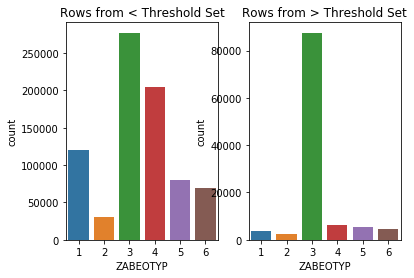

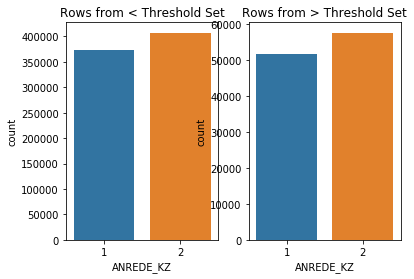

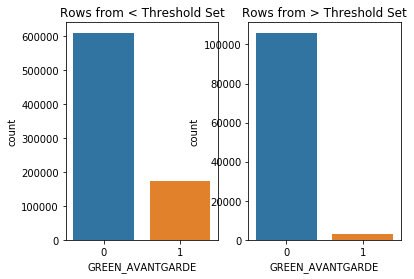

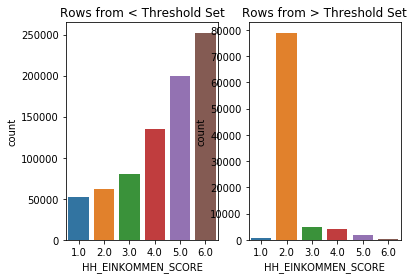

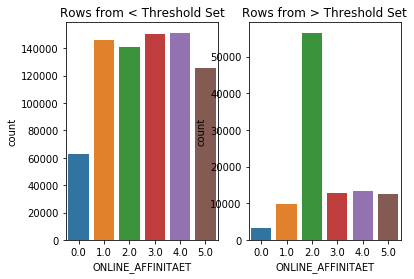

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# based on the analysis in section 1.1.1, we will select the following columns for this analysis
# ZABEOTYP:        0% missing/na
# ANREDE_KZ:       0% missing/na
# GREEN_AVANTGARDE: 0% missing/na
# HH_EINKOMMEN_SCORE: 2% missing/na
# ONLINE_AFFINITAET: 1% missing/na

cols_to_compare = ['ZABEOTYP', 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'HH_EINKOMMEN_SCORE', 'ONLINE_AFFINITAET']
compare_cols_lt = lt_df[cols_to_compare]
compare_cols_gt = gt_df[cols_to_compare]

def plot_compare_cols(column, idx):
    plt.figure(idx)
    plt.subplot(1, 2, 1)
    plt.title('Rows from < Threshold Set')
    sns.countplot(x=column, data=compare_cols_lt[column].to_frame().reset_index())

    plt.subplot(1, 2, 2)
    plt.title('Rows from > Threshold Set')
    sns.countplot(x=column, data=compare_cols_gt[column].to_frame().reset_index())
    

for idx, col in enumerate(cols_to_compare):
    plot_compare_cols(col, idx)


#### Discussion 1.1.3: Assess Missing Data in Each Row


For the five columns compared above, it appears that for the most part, the distribution of values for columns between the two subsets are sufficiently different such that dropping the rows doesn't seem to be a good idea. It's not completely clear-cut, though. If you look at the second and third side-by-side plots, that data seems to be similarly distributed. But since the other three have pretty different distributions, I'm going to stick with my initial assessment: don't just drop the rows with missing values.

In [16]:
# based on instructions above, continue analysis only with
# data rows that have fewer missing/na values

data = lt_df

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
print(Counter(list(feat_info['type'])))

Counter({'ordinal': 49, 'categorical': 21, 'numeric': 7, 'mixed': 7, 'interval': 1})


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# determine which columns are categorical
# feat_info.head()
cat_cols = list(feat_info[feat_info.type == 'categorical'].attribute)
print(cat_cols)

binary_num = []
binary_non_num = []
multi = []
for col in cat_cols:
    if col in data: # some columns have already been removed
        counter = Counter(data[col].dropna())
        if len(counter.keys()) == 2:
            if str(list(counter.keys())[0]).replace('.', '').isdigit():
                binary_num.append(col)
            else:
                print(f'col: {col}, {counter}\n')
                binary_non_num.append(col)
        else:
            print(f'col: {col}, {counter}\n')
            multi.append(col)
print(f'binary_num: {binary_num}')
print(f'binary_non_num: {binary_non_num}')
print(f'multi: {multi}')
                
        

['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
col: CJT_GESAMTTYP, Counter({4.0: 193740, 3.0: 143795, 2.0: 139828, 5.0: 109463, 6.0: 99083, 1.0: 91492})

col: FINANZTYP, Counter({6: 287209, 1: 192917, 5: 104718, 2: 102490, 4: 55135, 3: 38811})

col: GFK_URLAUBERTYP, Counter({12.0: 125750, 10.0: 101411, 8.0: 81903, 11.0: 73959, 5.0: 69938, 4.0: 60181, 9.0: 55754, 3.0: 52946, 1.0: 50174, 7.0: 40090, 2.0: 39748, 6.0: 25547})

col: LP_FAMILIE_FEIN, Counter({1.0: 395611, 10.0: 127279, 2.0: 96213, 11.0: 48237, 8.0: 21336, 7.0: 18705, 4.0: 11255, 5.0: 10978, 9.0: 10291, 6.0: 7767, 3.0: 4399})

col: LP_FAMILIE_GROB, Counter({1.0: 395611, 5.0: 185807, 2.0: 96213, 4.0: 47808, 3.0: 26632})

col: LP_STATUS_FEIN, Cou

In [19]:
# Re-encode categorical variable(s) to be kept in the analysis.

# re-encode string binary values to numeric binary values
data['OST_WEST_KZ'] = data['OST_WEST_KZ'].replace({'W': 1, 'O': 0})

# re-encode multi-category cols via dummy variables
for col in multi:
    print(f'replacing col: {col}')
    data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)
    data = data.drop(col, axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


replacing col: CJT_GESAMTTYP
replacing col: FINANZTYP
replacing col: GFK_URLAUBERTYP
replacing col: LP_FAMILIE_FEIN
replacing col: LP_FAMILIE_GROB
replacing col: LP_STATUS_FEIN
replacing col: LP_STATUS_GROB
replacing col: NATIONALITAET_KZ
replacing col: SHOPPER_TYP
replacing col: ZABEOTYP
replacing col: GEBAEUDETYP
replacing col: CAMEO_DEUG_2015
replacing col: CAMEO_DEU_2015


In [20]:
# sanity check: LGTM!
print([c for c in data])

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8

#### Discussion 1.2.1: Re-Encode Categorical Features

I found four binary (numerical) columns. Per the instructions, I didn't change the values of these, I just left them.

I found one binary (non-numerical) column. Per the instructions, I re-encoded the values in this column from 'W' and 'O' to 1 and 0, respectively (mainly because O looks like a 0).

I found 12 multi-value categorical columns. We had a choice here to discard these columns or to re-encode them using dummy variables. I decided it would be less work to re-encode them using dummy values using the loop above than to spend time determining whether to keep them. If it turns out that those columns aren't useful, they should be dropped later in PCA. If it turns out that those columns are useful, then great, we have them available.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [21]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# from data dictionary:
'''
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''
# use replacement dictionary to create two new columns: PJ_DECADE and PJ_MOVEMENT_AVANTGARDE
# print(Counter(data['PRAEGENDE_JUGENDJAHRE'].dropna()))
replacement_dict = {
    1.0: 40,
    2.0: 40,
    3.0: 50,
    4.0: 50,
    5.0: 60,
    6.0: 60,
    7.0: 60,
    8.0: 70,
    9.0: 70,
    10.0: 80,
    11.0: 80,
    12.0: 80,
    13.0: 80,
    14.0: 90,
    15.0: 90
}
data['PJ_DECADE'] = data['PRAEGENDE_JUGENDJAHRE'].replace(replacement_dict)
# data['PJ_DECADE'].head()

replacement_dict = {
    1.0: 0,
    2.0: 1,
    3.0: 0,
    4.0: 1,
    5.0: 0,
    6.0: 1,
    7.0: 1,
    8.0: 0,
    9.0: 1,
    10.0: 0,
    11.0: 1,
    12.0: 0,
    13.0: 1,
    14.0: 0,
    15.0: 1
}
data['PJ_MOVEMENT_AVANTGARDE'] = data['PRAEGENDE_JUGENDJAHRE'].replace(replacement_dict)
# data['PJ_MOVEMENT_AVANTGARDE'].head()

# finally, drop original column
data = data.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
# data.head()

In [22]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.


data['CAMEO_INTL_2015_WEALTH'] = data['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if str(x).isdigit() else -1).astype(int)
# data['CAMEO_INTL_2015_WEALTH'].astype(int).head()
data['CAMEO_INTL_2015_WEALTH'] = data['CAMEO_INTL_2015_WEALTH'].replace({-1: np.nan})
# data['CAMEO_INTL_2015'].head()

data['CAMEO_INTL_2015_LIFE_STAGE'] = data['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if str(x).isdigit() else -1).astype(int)
data['CAMEO_INTL_2015_LIFE_STAGE'] = data['CAMEO_INTL_2015_LIFE_STAGE'].replace({-1: np.nan})
# data['CAMEO_INTL_2015_LIFE_STAGE'].head()

# then drop orig column
data = data.drop(['CAMEO_INTL_2015'], axis=1)
data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PJ_DECADE,PJ_MOVEMENT_AVANTGARDE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,90.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,90.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,70.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,70.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,50.0,0.0,5.0,4.0


In [23]:
# investigate five other mixed variable columns

mixed_feats = sorted(list(feat_info[feat_info['type'] == 'mixed'].attribute))
# remove features already engineered
mixed_feats.remove('CAMEO_INTL_2015')
mixed_feats.remove('PRAEGENDE_JUGENDJAHRE')
# remove features already removed for having too many na values in the column
for c in na_cols:
    if c in mixed_feats:
        mixed_feats.remove(c)
print(mixed_feats)

# based on analysis covered in discussion below, remove LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB features
data = data.drop('LP_LEBENSPHASE_FEIN', axis=1)
data = data.drop('LP_LEBENSPHASE_GROB', axis=1)
data.head()

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX', 'WOHNLAGE']


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PJ_DECADE,PJ_MOVEMENT_AVANTGARDE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,90.0,0.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,90.0,1.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,70.0,0.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,70.0,0.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,50.0,0.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

I updated the two highlighted mixed-type features based on the suggestions from the notebook. I created four new columns, total: two for PRAEGENDE_JUGENDJAHRE (PJ_DECADE and PJ_MOVEMENT_AVANTGARDE) and two for CAMEO_INTL_2015 (CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFE_STAGE). I went ahead and got rid of the original columns at this point so I don't forget to do that later.

There was one mixed-type column that I already dropped earlier in the cleaning due to high number of na's in the data: KBA05_BAUMAX.

That left four columns to investigate: LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PLZ8_BAUMAX, and WOHNLAGE.

With PLZ8_BAUMAX, I'm not sure why this feature was labeled as mixed type. It's seems like it's already categorical data. I didn't see any point in changing that feature, so I left it. Same thing with WOHNLAGE.

Both of the LP_LEBENSPHASE features are related to wealth and life stage, with one being at a finer scale. Both of these features seemed redundant with the CAMEO_INTL_2015 feature, which was already engineered to be split into two features. So I dropped these two LP_LEBENSPHASE features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [24]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# i believe this has already been done in previous steps
# so let's just print out some info for comparison to following data cleaning step
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781280 entries, 1 to 891220
Columns: 194 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFE_STAGE
dtypes: float64(43), int64(23), uint8(128)
memory usage: 494.7 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [25]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    
    ## Put in code here to execute all main cleaning steps:
    ## convert missing value codes into NaNs, ...
    
    # re-generate replacement dictionary for missing_or_unknowns
    # using pre-defined function above
    replacement_dict = dict(zip(
        feat_info['attribute'],
        feat_info['missing_or_unknown'].apply(make_col_val_replacement_dict)
    ))
    # do the replacement
    df = df.replace(replacement_dict)
    
    
    ## remove selected columns and rows, ...
    
    # not going to repeat the analysis for na_cols,
    # just going to duplicate the actions here
    df = df.drop(na_cols, axis=1)
    
    # for rows, i will have to do the counting again
    # because there are a different number of rows in the new dataset
    counts_with_row_idx = get_na_counts_row(df)
    threshold = 12 # using the same threshold, though
    lt_threshold_idx = [c[1] for c in counts_with_row_idx if c[0] < threshold]
    df = df.iloc[lt_threshold_idx, :]
    
    
    ## select, re-encode, and engineer column values.

    # just doing the same thing that I did before
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W': 1, 'O': 0})
    print('here are columns in df right now')
    print([col for col in df])
    for col in multi:
        print(f'replacing col: {col}')
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        df = df.drop(col, axis=1)
    replacement_dict = {
        1.0: 40,
        2.0: 40,
        3.0: 50,
        4.0: 50,
        5.0: 60,
        6.0: 60,
        7.0: 60,
        8.0: 70,
        9.0: 70,
        10.0: 80,
        11.0: 80,
        12.0: 80,
        13.0: 80,
        14.0: 90,
        15.0: 90
    }
    df['PJ_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].replace(replacement_dict)
    replacement_dict = {
        1.0: 0,
        2.0: 1,
        3.0: 0,
        4.0: 1,
        5.0: 0,
        6.0: 1,
        7.0: 1,
        8.0: 0,
        9.0: 1,
        10.0: 0,
        11.0: 1,
        12.0: 0,
        13.0: 1,
        14.0: 0,
        15.0: 1
    }
    df['PJ_MOVEMENT_AVANTGARDE'] = df['PRAEGENDE_JUGENDJAHRE'].replace(replacement_dict)
    df = df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if str(x).isdigit() else -1).astype(int)
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015_WEALTH'].replace({-1: np.nan})
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if str(x).isdigit() else -1).astype(int)
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015_LIFE_STAGE'].replace({-1: np.nan})
    df = df.drop(['CAMEO_INTL_2015'], axis=1)
    df = df.drop('LP_LEBENSPHASE_FEIN', axis=1)
    df = df.drop('LP_LEBENSPHASE_GROB', axis=1)
    
    print(df.info())

    
    ## Return the cleaned dataframe.
    return df
    

In [25]:
# gotta test it out, right?
# i end up doing this later, too
other_data = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
other_data = clean_data(other_data)

here are columns in df right now
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANT

In [26]:
# i noticed that customer data has 193 columns, one less than the 194 columns from general population data: WTF!?
# using code below, i identified which column that is and it actually makes sense:
# GEBAEUDETYP_5.0 is a dummy column and
# customer data must not have any GEBAEUDETYP records with a value of 5.
# we may need to know this later, but for now, it appears that the clean data function seems to work

data_cols = set([c for c in data])
other_data_cols = set([c for c in other_data])
print(data_cols.difference(other_data_cols))

{'GEBAEUDETYP_5.0'}


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [26]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

data_imp = imp.fit_transform(data)
# data_imp_df = pd.DataFrame(data_imp)

In [27]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)

data_scaled = scaler.fit_transform(data_imp)
data_scaled_df = pd.DataFrame(data_scaled)
(data_scaled_df).describe()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
count,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,...,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05,7.812800e+05
mean,5.915035e-16,2.319668e-16,-8.629864e-17,9.884918e-17,3.037596e-18,-5.554980e-17,-7.097424e-17,7.173819e-17,-7.903205e-17,-6.955094e-16,...,-4.256272e-17,9.040940e-17,6.666340e-18,-3.973430e-17,-1.716151e-17,5.008395e-17,-1.756167e-16,-2.056561e-16,-5.834548e-16,2.365505e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.767072e+00,-1.043466e+00,-1.488353e+00,-1.151150e+00,-1.771603e+00,-1.247915e+00,-1.172966e+00,-1.531810e+00,-5.310878e-01,-1.630640e+00,...,-1.511957e-01,-1.637697e-01,-1.910479e-01,-1.812993e-01,-1.942707e-01,-8.924159e-02,-2.318828e+00,-5.525629e-01,-1.555854e+00,-1.260676e+00
25%,-7.841031e-01,-1.043466e+00,-7.627409e-01,-1.151150e+00,-1.045210e+00,-1.247915e+00,-1.172966e+00,-8.170429e-01,-5.310878e-01,-2.759396e-01,...,-1.511957e-01,-1.637697e-01,-1.910479e-01,-1.812993e-01,-1.942707e-01,-8.924159e-02,-9.234783e-01,-5.525629e-01,-8.716792e-01,-1.260676e+00
50%,1.988659e-01,9.583443e-01,-3.712856e-02,1.939826e-01,4.075761e-01,1.095797e-01,-4.554911e-01,-1.022757e-01,-5.310878e-01,-2.759396e-01,...,-1.511957e-01,-1.637697e-01,-1.910479e-01,-1.812993e-01,-1.942707e-01,-8.924159e-02,0.000000e+00,-5.525629e-01,4.966710e-01,8.710412e-02
75%,1.181835e+00,9.583443e-01,6.884837e-01,8.665489e-01,1.133969e+00,7.883271e-01,9.794585e-01,6.124915e-01,-5.310878e-01,1.078761e+00,...,-1.511957e-01,-1.637697e-01,-1.910479e-01,-1.812993e-01,-1.942707e-01,-8.924159e-02,1.169547e+00,-2.020140e-16,1.180846e+00,7.609944e-01
max,1.181835e+00,9.583443e-01,1.414096e+00,1.539115e+00,1.133969e+00,1.467074e+00,1.696933e+00,1.327259e+00,1.882928e+00,1.078761e+00,...,6.613946e+00,6.106136e+00,5.234290e+00,5.515741e+00,5.147456e+00,1.120554e+01,1.169547e+00,1.873544e+00,1.180846e+00,1.434885e+00


### Discussion 2.1: Apply Feature Scaling

A simple imputer seemed like a better choice than just dropping all the data because there's a pretty decent amount of rows/cols that have at least some missing data. I was hoping to use a KNN imputer, but that's available starting in version 0.22 of sklearn, and this workspace is using 0.19. Apparently, there's only one imputer available in sklearn 0.19, so that's the one that I went with.

Regarding the scaling of the values, that was pretty straight-forward: I followed the documention to scale the values with a mean of 0 and std of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [28]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

# start w/ 100 b/c it's more than half of number of features
pca = PCA(n_components=100)
data_pca = pca.fit_transform(data_scaled)

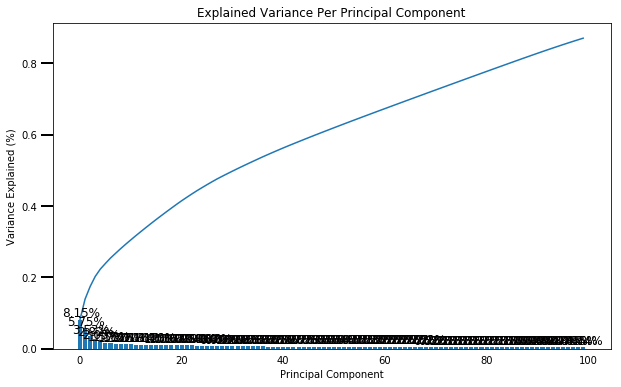

In [29]:
# Investigate the variance accounted for by each principal component.


# NOTE: this code was taken from helper file provided by instructor in PCA lesson
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

scree_plot(pca)

In [ ]:
# Re-apply PCA to the data while selecting for number of components to retain.

# NA, see discussion below.


### Discussion 2.2: Perform Dimensionality Reduction

On my first PCA attempt, I followed the instructions and chose a number of components that was at least half of the number of features: 100. After choosing the number, doing the PCA, and plotting the results using a helper function that was provided to us in the PCA lesson of this course, it appears that using n=100 accounts for roughly 85% of the variance in the data. That number seemed high enough to me based on the 'Interpret PCA Results' exercise from this course. So we'll move on with the existing components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [31]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# sanity checking length of weights for component 0 against list of columns from original data
# print(len(pca.components_[0]))
# print(len(list(data)))

def print_features_sorted_by_component_weights(component_index):
    features_with_weights = list(zip(list(data), pca.components_[component_index]))
    features_with_weights.sort(key=lambda x: x[1])
    for fww in features_with_weights:
        print(fww)
    
print_features_sorted_by_component_weights(0)

('MOBI_REGIO', -0.2030248693257112)
('KBA05_ANTG1', -0.18960847945613377)
('PLZ8_ANTG1', -0.18457355381270826)
('FINANZ_MINIMALIST', -0.18440040161629817)
('KBA05_GBZ', -0.18050743630688001)
('KONSUMNAEHE', -0.13743234810473115)
('PLZ8_GBZ', -0.13571000015633994)
('INNENSTADT', -0.12922660574527514)
('LP_STATUS_GROB_4.0', -0.11094650832077593)
('LP_STATUS_FEIN_10.0', -0.11031612784229287)
('LP_STATUS_GROB_5.0', -0.11031612784229287)
('CAMEO_INTL_2015_LIFE_STAGE', -0.10898850776252438)
('LP_STATUS_FEIN_9.0', -0.10890443637653884)
('GREEN_AVANTGARDE', -0.10021061983708413)
('PJ_MOVEMENT_AVANTGARDE', -0.097924581649530704)
('GEBAEUDETYP_RASTER', -0.097906354724225125)
('BALLRAUM', -0.097855707174419396)
('ZABEOTYP_1', -0.094825387277121476)
('GEBAEUDETYP_1.0', -0.08812643717684096)
('CAMEO_DEUG_2015_2', -0.087519974805429751)
('ANZ_PERSONEN', -0.08194938248858584)
('FINANZ_VORSORGER', -0.078336743842134959)
('ALTERSKATEGORIE_GROB', -0.077851619403958905)
('FINANZTYP_2', -0.075643552670035

In [32]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_features_sorted_by_component_weights(1)

('PJ_DECADE', -0.2393083923526797)
('FINANZ_SPARER', -0.22993986622943885)
('SEMIO_REL', -0.21648405433488613)
('FINANZ_UNAUFFAELLIGER', -0.21558201090074597)
('SEMIO_TRADV', -0.20923833032825956)
('SEMIO_PFLICHT', -0.20853140518779498)
('FINANZ_ANLEGER', -0.20666350927513427)
('SEMIO_RAT', -0.17059769135907041)
('SEMIO_KULT', -0.16586442353753314)
('ONLINE_AFFINITAET', -0.15813164058722681)
('FINANZTYP_1', -0.13636443965980044)
('SEMIO_FAM', -0.13416833663587019)
('SEMIO_MAT', -0.13093845592054887)
('ZABEOTYP_4', -0.10810643249504617)
('LP_STATUS_FEIN_2.0', -0.097948387246648075)
('ZABEOTYP_5', -0.093425866943235347)
('FINANZTYP_4', -0.089167023343050794)
('LP_STATUS_FEIN_5.0', -0.080221559965068689)
('GFK_URLAUBERTYP_9.0', -0.073058045233242511)
('FINANZTYP_3', -0.071576349664948621)
('LP_FAMILIE_GROB_4.0', -0.067254699246042687)
('SEMIO_SOZ', -0.061914684814127652)
('ANZ_PERSONEN', -0.061084833475117083)
('PLZ8_ANTG1', -0.061063884453260255)
('KBA05_GBZ', -0.057419383213318201)
('MO

In [33]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_features_sorted_by_component_weights(2)

('ANREDE_KZ', -0.34069684892384389)
('SEMIO_KAEM', -0.3100314164840986)
('SEMIO_DOM', -0.27606106164458966)
('SEMIO_KRIT', -0.26364320392830715)
('SEMIO_ERL', -0.20640832585436092)
('FINANZ_ANLEGER', -0.15403448427957483)
('SEMIO_RAT', -0.15062749037018927)
('FINANZTYP_1', -0.10012478245236595)
('SHOPPER_TYP_2.0', -0.093921256770551104)
('LP_STATUS_FEIN_2.0', -0.080707580797801784)
('LP_STATUS_FEIN_4.0', -0.078823504228166683)
('FINANZ_HAUSBAUER', -0.067935301311296992)
('ZABEOTYP_4', -0.062841061636148637)
('INNENSTADT', -0.061671719115186117)
('BALLRAUM', -0.055657987396483678)
('FINANZ_SPARER', -0.054149302609723726)
('LP_FAMILIE_GROB_3.0', -0.054028208221083021)
('KONSUMNAEHE', -0.050287867647322397)
('WOHNLAGE', -0.05003566119209072)
('HH_EINKOMMEN_SCORE', -0.049747265422213444)
('SHOPPER_TYP_3.0', -0.047962826403212845)
('PJ_DECADE', -0.046752433252710723)
('PLZ8_ANTG1', -0.046018742882572045)
('KKK', -0.04554482667647107)
('ZABEOTYP_3', -0.042115766772303047)
('FINANZ_UNAUFFAELL

### Discussion 2.3: Interpret Principal Components

I'll take a look at the first and last two items for each of the three components and try to make sense of them.

**PCA 0 Bottom Two:**

('MOBI_REGIO', -0.20302488900716492)

- negative correlation to movement
- higher val means they stay put

('KBA05_ANTG1', -0.18960849821331172)

- negative correlation to share of 1-2 family homes
- higher val means fewer 1-2 family homes (i.e. poorer neighborhoods)

**PCA 0 Top Two:**

('PLZ8_ANTG3', 0.18409806590579553)

- positive correlation to number of 6-10 family houses
- higher val means more 6-10 family homes (i.e. poorer neighborhoods)

('LP_STATUS_GROB_1.0', 0.19233503066811622)

- positive correlation to low-income earners
- higher val means lower income

**PCA 1 Bottom Two:**

('PJ_DECADE', -0.2393083902366101)

- negative correlation to older decade in 1900s
- higher val means they were born more recently

('FINANZ_SPARER', -0.22993986949847653)

- negative correlation to being a 'money saver'
- higher val means they like to spend money

**PCA 1 Top Two:**

('FINANZ_VORSORGER', 0.22079775851584335)

- positive correlation to being 'prepared'
- higher val means they're more prepared

('ALTERSKATEGORIE_GROB', 0.23511891630316312)

- positive correlation to age
- higher val means they're older

**PCA 2 Bottom Two:**

('ANREDE_KZ', -0.34069685396588645)

- negative correlation to a gender value (1=male, 2=female)
- higher val means they're female

('SEMIO_KAEM', -0.31003135229715623)

- negative correlation to combatitive attitude
- higher val means they're less aggressive

**PCA 2 Top Two:**

('SEMIO_FAM', 0.25686049408582423)

- positive correlation to being family minded
- higher val means they're more family minded

('SEMIO_VERT', 0.31664309187270295)

- positive correlation to being 'dreamful'
- higher val means they're more of a dreamer

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

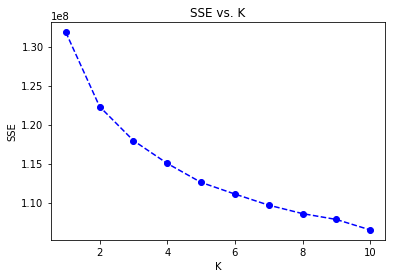

In [43]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    
# NOTE: all code in this cell was taken from solution to an exercise in the k-means clustering lesson
from sklearn.cluster import KMeans

def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

scores = []
centers = list(range(1,11)) # going with the recommendation of 10

for center in centers:
    scores.append(get_kmeans_score(data_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# --> see previous cell for this elbow plot

In [30]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
preds = kmeans.fit_predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population

I ran the code above to get an elbow curve plot. I also paid attention to the note in the instructions that said I should run cluster counts through at least 10 clusters to get the full picture, so that's what I did. I found it difficult to determine where the elbow of this curve is. I ended up choosing 5 as the number of clusters to use because from n=4 to n=5, the SSE drops from 1.150 to about 1.125 (about 0.025) and from n=5 to n=6, the SSE drops from about 1.125 to 1.110 (about 0.015) and every additional cluster seems to have minimal impact on the SSE.

You can even see that in the plot visually, where going from 1 to 2, and 2 to 3 have a fairly big jump. Going from 4 to 5 has what is the last big jump for a while.

So five clusters it is!

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [31]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [32]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)
customers_imp = imp.fit_transform(customers_clean)
print('imputed')
customers_scaled = scaler.fit_transform(customers_imp)
print('scaled')
pca = PCA(n_components=100)
customers_pca = pca.fit_transform(customers_scaled)
print("pca'd")
kmeans = KMeans(n_clusters=5)
customer_preds = kmeans.fit_predict(customers_pca)
print('clustered!')

here are columns in df right now
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANT

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

(array([ 14973.,  29436.,  43429.,  23339.,  28052.]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <a list of 5 Patch objects>)

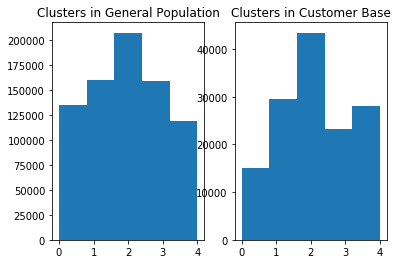

In [33]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

## getting my bearings...
# print(preds)
# print(len(preds))
# print(customer_preds)
# print(len(customer_preds))


# in each case, we have five clusters here. let's just roll with that
plt.figure(0)
plt.subplot(1, 2, 1)
plt.title('Clusters in General Population')
plt.hist(preds, bins=5)

plt.subplot(1, 2, 2)
plt.title('Clusters in Customer Base')
plt.hist(customer_preds, bins=5)

In [67]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# --> Cluster 2 (zero-indexed) seems to be represented in a higher proportion than in the general population.
print(customer_preds[0:20])
# we could look at customers: 0,4,5,6,9,13,14
cust_inv_trans = []
for idx in [0,4,5,6,9,13,14]:
    pca_inv = pca.inverse_transform(customers_pca[idx])
    scaler_inv = scaler.inverse_transform(pca_inv)
    cust_inv_trans.append(scaler_inv)

# actually, let's look at just one customer, at least to start

# now let's convert this to a dataframe and get the column names so we can take a look and attempt to make sense of the values
cust_inversed = pd.DataFrame(cust_inv_trans)
cust_cols_with_vals = list(zip([c for c in customers_clean], cust_inversed.loc[[0]].values.flatten().tolist()))
for c in cust_cols_with_vals:
    print(f'{c[0]}: {c[1]}')

[2 3 4 1 2 2 2 1 0 2 4 0 1 2 2 0 1 3 0 1]
193
ALTERSKATEGORIE_GROB: 4.273048284669074
ANREDE_KZ: 0.9454753698828166
FINANZ_MINIMALIST: 5.0143796567615055
FINANZ_SPARER: 0.9244420896169299
FINANZ_VORSORGER: 5.031812667629248
FINANZ_ANLEGER: 0.9054185542991356
FINANZ_UNAUFFAELLIGER: 1.8870836346908315
FINANZ_HAUSBAUER: 2.4560699229061713
GREEN_AVANTGARDE: 0.933876298471899
HEALTH_TYP: 1.186712561208457
RETOURTYP_BK_S: 4.838077861858981
SEMIO_SOZ: 5.597444989327566
SEMIO_FAM: 4.4962504945982245
SEMIO_REL: 2.8927095094612856
SEMIO_MAT: 5.226134845451115
SEMIO_VERT: 7.098959640881635
SEMIO_LUST: 7.589612270795191
SEMIO_ERL: 3.7544116911214154
SEMIO_KULT: 4.273298496756593
SEMIO_RAT: 1.7019351122468682
SEMIO_KRIT: 3.0115517583465286
SEMIO_DOM: 2.1149778291571346
SEMIO_KAEM: 1.2479460498136792
SEMIO_PFLICHT: 1.822453174034527
SEMIO_TRADV: 1.1768404074866736
SOHO_KZ: -0.009116027806703758
VERS_TYP: 0.844482142088516
ANZ_PERSONEN: 1.959317905069499
ANZ_TITEL: -0.007637670122995009
HH_EINKOMMEN_

let's look at most significant columns pointed out from PCA 0 for this customer
'MOBI_REGIO' (4.13), 'KBA05_ANTG1' (2.64), 'PLZ8_ANTG3' (1.02), 'LP_STATUS_GROB_5.0' (0.01)
- low movement
- average share of 1-2 family houses
- lower share of 6-10 family houses
- a top earner

We could also look at a few more
'FINANZ_SPARER' (0.92), 'ALTERSKATEGORIE_GROB' (4.27)
- definitely a money saver
- over 60

In [71]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# --> Cluster 4 (zero-indexed) seems to be represented in a lower proportion than in the general population.
print(customer_preds[0:20])
# looks like customer 2 (zero-indexed is a winner)
cust_inv_trans = []
for idx in [2]:
    pca_inv = pca.inverse_transform(customers_pca[idx])
    scaler_inv = scaler.inverse_transform(pca_inv)
    cust_inv_trans.append(scaler_inv)

# let's again look at just one customer, at least to start

# now let's convert this to a dataframe and get the column names so we can take a look and attempt to make sense of the values
cust_inversed = pd.DataFrame(cust_inv_trans)
cust_cols_with_vals = list(zip([c for c in customers_clean], cust_inversed.loc[[0]].values.flatten().tolist()))
for c in cust_cols_with_vals:
    print(f'{c[0]}: {c[1]}')

[2 3 4 1 2 2 2 1 0 2 4 0 1 2 2 0 1 3 0 1]
ALTERSKATEGORIE_GROB: 3.6414383806417794
ANREDE_KZ: 0.9889918826443063
FINANZ_MINIMALIST: 5.207660031876519
FINANZ_SPARER: 1.1241205856630585
FINANZ_VORSORGER: 5.085613680265007
FINANZ_ANLEGER: 1.8223911297896391
FINANZ_UNAUFFAELLIGER: 0.7968035992772025
FINANZ_HAUSBAUER: 1.8531009501499474
GREEN_AVANTGARDE: -0.09663999726229788
HEALTH_TYP: 2.097135066664248
RETOURTYP_BK_S: 3.6548706817225822
SEMIO_SOZ: 4.154708557343158
SEMIO_FAM: 4.97743781934328
SEMIO_REL: 3.846563144137534
SEMIO_MAT: 2.5635135987893207
SEMIO_VERT: 5.95535461816218
SEMIO_LUST: 5.2593366188888755
SEMIO_ERL: 3.9198731376263742
SEMIO_KULT: 4.9390927994768745
SEMIO_RAT: 2.208121407698391
SEMIO_KRIT: 2.2104805043207945
SEMIO_DOM: 2.6804129711563647
SEMIO_KAEM: 2.0109315498253526
SEMIO_PFLICHT: 2.911767870411434
SEMIO_TRADV: 3.6922911052956664
SOHO_KZ: 0.008486490548680578
VERS_TYP: 1.4452170956258277
ANZ_PERSONEN: -0.1403879185024297
ANZ_TITEL: -0.001418739545684066
HH_EINKOMMEN_

We will look for values in the same columns for the people in the under-represented cluster.

let's look at most significant columns pointed out from PCA 0 for this customer
'MOBI_REGIO' (4.09), 'KBA05_ANTG1' (2.77), 'PLZ8_ANTG3' (0.60), 'LP_STATUS_GROB_4.0' (1.09)
- low movement
- high share of 1-2 family homes
- low/no 6-10 family homes
- houseowner (relatively wealthy, but not at the top)

We could also look at a few more
'FINANZ_SPARER' (5.09), 'ALTERSKATEGORIE_GROB' (3.64)
- not a money saver at all
- roughly between 45 and 60

### Discussion 3.3: Compare Customer Data to Demographics Data


Based on the analysis laid out above, I inferred that the following segment is relatively popular with the company: a top earner, money saver, over 60.

Based on the analysis laid out above, I inferred that the following segment is relatively unpopular with the company: homeowner (wealthy, but not at the top), not a money saver at all, and rougly between 45 and 60.

To be honest, I found this last section 3.3, to be one of the most difficult portions of this project. I used the .inverse_transform() method because I had a difficult time conceptually tying PCA rows to specific clusters. I found it easier to use .inverse_transform to get the data back to its original form and then tie that to specific original data columns. Hopefully I'm not totally off-base here.

Even with those challenges, I thought this was a fun project.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.